## Fields and Factories

Within the IMAGINE pipeline, spatially varying physical quantities are represented by
[Field objects](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#module-imagine.fields).
This can be a *scalar*, as the number density of thermal electrons, or a *vector*, as the Galactic magnetic field. 



In order to extend or personalise adding in one's own model for an specific field, one needs to follow a small number of simple steps:  

1. choose a **coordinate grid** where your model will be evaluated,
2. write a **field class**, and
3. write a **field factory** class.

The **field objects** will do the actual computation of the physical field, given a set of physical parameters and a coordinate grid. 
The **field factory objects** take care of book-keeping tasks: e.g. they hold the parameter ranges and default values, and translate the dimensionless parameters used by the sampler (always in the interval $[0,1]$) to physical parameters, and hold the prior information on the parameter values.

### Coordinate grid

You can create your own coordinate grid by subclassing `imagine.fields.grid.BaseGrid`.  The only thing which has to actually be programmed in the new sub-class is a
method overriding `generate_coordinates()`, which produces a dictionary of numpy arrays containing coordinates in *either* cartesian,
cylindrical or spherical coordinates (generally assumed, in Galactic contexts, to be centred in the centre of the Milky Way).

Typically, however, it is sufficient to use a simple grid with coordinates uniformly-spaced in cartesian, spherical or cylindrical 
coordinates. This can be done using the `UniformGrid` class. `UniformGrid` objects are initialized with the arguments: `box`, which contains the ranges of each coordinate in $\rm kpc$ or $\rm rad$; `resolution`, a list of integers containing the number of grid points on each dimension; and `grid_type`, which can be either 'cartesian' (default), 'cylindrical' or 'spherical'.

In [ ]:
import imagine as img
import numpy as np
import astropy.units as u

# A cartesian grid can be constructed as follows
cartesian_grid = img.UniformGrid(box=[[-15*u.kpc, 15*u.kpc],
                                      [-15*u.kpc, 15*u.kpc],
                                      [-15*u.kpc, 15*u.kpc]],
                          resolution = [15,15,15])

# For cylindrical grid, the limits are specified assuming 
# the order: r (cylindrical), phi, z
cylindrical_grid = img.UniformGrid(box=[[0.25*u.kpc, 15*u.kpc],
                                        [-180*u.deg, np.pi*u.rad],
                                        [-15*u.kpc, 15*u.kpc]],
                      resolution = [9,12,9],
                      grid_type = 'cylindrical')

# For spherical grid, the limits are specified assuming 
# the order: r (spherical), theta, phi (azimuth)
spherical_grid = img.UniformGrid(box=[[0*u.kpc, 15*u.kpc],
                                      [0*u.rad, np.pi*u.rad], 
                                      [-np.pi*u.rad,np.pi*u.rad]],
                      resolution = [12,10,10],
                      grid_type = 'spherical')

The grid object will produce the grid only when the a coordinate value is first accessed, 
through the properties 'x', 'y','z','r_cylindrical','r_spherical', 'theta' and 'phi'. 

The grid object also takes care of any coordinate conversions that are needed, for example:

In [2]:
print(spherical_grid.x[5,5,5], cartesian_grid.r_spherical[5,5,5])

6.309658489079476 kpc 7.423074889580904 kpc


In the following figure we illustrate the effects of different choices of 'grid_type' while using UniformGrid. 

(Note that, for plotting purposes, everything is converted to cartesian coordinates)

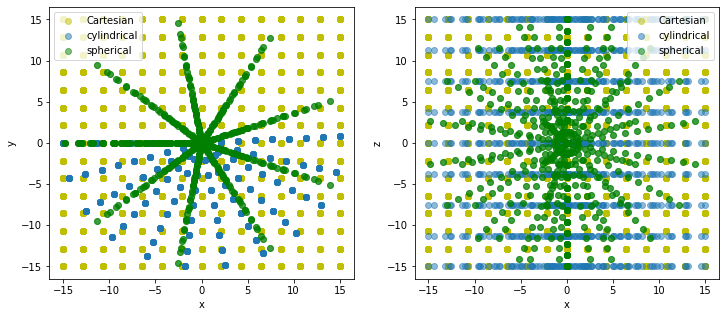

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(cartesian_grid.x, cartesian_grid.y, color='y', label='Cartesian', alpha=0.5)
plt.scatter(cylindrical_grid.x, cylindrical_grid.y, label='cylindrical', alpha=0.5)
plt.scatter(spherical_grid.x, spherical_grid.y, color='g', label='spherical', alpha=0.5)
plt.xlabel('x'); plt.ylabel('y')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(cartesian_grid.x, cartesian_grid.z, color='y', label='Cartesian', alpha=0.5)
plt.scatter(cylindrical_grid.x, cylindrical_grid.z, label='cylindrical', alpha=0.5)
plt.scatter(spherical_grid.x, spherical_grid.z, label='spherical', color='g', alpha=0.5)
plt.xlabel('x'); plt.ylabel('z')
plt.legend();




### Field objects

As we mentioned before, `Field` objects handle the calculation of any physical field.

To ensure that your new personalised field is compatible with any simulator,
it needs to be a subclass of one of the [pre-defined field classes](https://imagine-code.readthedocs.io/en/latest/components.html#fields). Some examples of which are:

 * `MagneticField`
 * `ThermalElectronDensity`
 * `CosmicRayDistribution`

Let us illustrate this by defining a thermal electron number density field 
which decays exponentially with cylindrical radius, $R$, .
$$ n_e(R) = n_{e,0} e^{-R/R_e} e^{-|z|/h_e} $$
This has three parameters: the number density of thermal electrons at the 
centre, $n_{e,0}$, the scale radius, $R_e$, and the scale height, $h_e$.



In [4]:
from imagine import ThermalElectronDensityField

class ExponentialThermalElectrons(ThermalElectronDensityField):
    """Example: thermal electron density of an (double) exponential disc"""
    
    field_name = 'exponential_disc_thermal_electrons'
    stochastic_field = False
    
    @property
    def field_checklist(self):
        return {'central_density' : None, 
                'scale_radius' : None,
                'scale_height' : None}
    
    def get_field(self, seed):
        R = self.grid.r_cylindrical
        z = self.grid.z
        Re = self.parameters['scale_radius']
        he = self.parameters['scale_height']
        n0 = self.parameters['central_density']
        
        return n0*np.exp(-R/Re)*np.exp(-np.abs(z/he))

With these few lines we have created our IMAGINE-compatible™ thermal electron density field class!

The class-attribute `field_name` allows one to keep track of which model we have used to generate our field. 

The `stochastic field` class-attribute tells whether the field is deterministic (i.e. the output depends only on the parameter values) or stochastic (i.e. the ouput is a random realisation which depends on a particular random seed). In this particular case we construct a deterministic field.

The `field_checklist` property is a dictionary whose keys are required parameters for this particular kind of field. The values in the dictionary can be used for specialized checking by some simulators (but can be left as `None` in the general case).

The function `get_field` is what actually computes the density field. Note that it can access an associated grid object, which is stored in the `grid` attribute, and a dictionary of parameters, stored in the `parameters` attribute. The `get_field` method takes a `seed` argument, which can is only used for stochastic fields (see later).

Let us now see this at work. First, let us creat an instance of `ExponentialThermalElectrons`. Any Field instance should be initialized 
providing a Grid object and a dictionary of parameters.

In [5]:
electron_distribution = ExponentialThermalElectrons(
    parameters={'central_density': 1.0*u.cm**-3,
                'scale_radius': 3.3*u.kpc,
                'scale_height': 3.3*u.kpc},
    grid=cartesian_grid)

We can access the field produced by `cr_distribution` using the `data` attribute. For example:

In [6]:
print('data is', type(electron_distribution.data), 'of length', len(electron_distribution.data))
print('an example slice of it is:')
electron_distribution.data[0][3:5,3:5,3:5]

data is <class 'list'> of length 1
an example slice of it is:


<Quantity [[[0.00189093, 0.00361981],
            [0.00289678, 0.0055453 ]],

           [[0.00289678, 0.0055453 ],
            [0.00473694, 0.00906791]]] 1 / cm3>

If we now wanted to plot the thermal electron density computed by this as a function of, say, *spherical radius*, $r_{\rm sph}$. This can be done in the following way

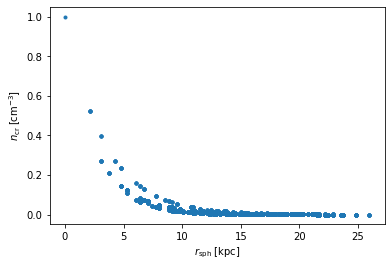

In [7]:
# The spherical radius can be read from the grid object
rspherical = electron_distribution.grid.r_spherical.ravel()
# The electron density is the data array
ne = electron_distribution.data[0].ravel()

plt.plot(rspherical, ne, '.')
plt.xlabel(r'$r_{\rm sph}\;[\rm kpc]$'); plt.ylabel(r'$n_{\rm cr}\;[\rm cm^{-3}]$');

Let us do another simple field example: a constant magnetic field.

It follows the same basic template.

In [8]:
from imagine import MagneticField
    
class ConstantMagneticField(MagneticField):
    """Example: constant magnetic field"""
    field_name = 'constantB'
    stochastic_field = True
    
    @property
    def field_checklist(self):
        return {'Bx': None, 'By': None, 'Bz': None}
    
    def get_field(self, seed):
        # Creates an empty array to store the result
        B = np.empty(self.data_shape) * self.parameters['Bx'].unit
        # For a magnetic field, the output must be of shape: 
        # (Nx,Ny,Nz,Nc) where Nc is the index of the component. 
        # Computes Bx
        B[:,:,:,0] = self.parameters['Bx']*np.ones(self.grid.shape)
        # Computes By
        B[:,:,:,1] = self.parameters['By']*np.ones(self.grid.shape)
        # Computes Bz
        B[:,:,:,2] = self.parameters['Bz']*np.ones(self.grid.shape)        
        return B

The main difference from the thermal electrons case is that the shape of the final array has to accomodate all the three components of the magnetic field.

As before, we can generate a realisation of this

In [9]:
p = {'Bx': 1.5*u.microgauss, 'By': 1e-10*u.Tesla, 'Bz': 0.1e-6*u.gauss}
B = ConstantMagneticField(parameters=p, grid=cartesian_grid)

And inspect how it went

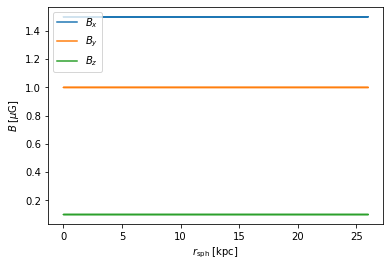

In [10]:
r_spherical = B.grid.r_spherical.ravel()

for i, name in enumerate(['x','y','z']):
    plt.plot(r_spherical, B.data[0][...,i].ravel(), 
             label='$B_{}$'.format(name))
plt.xlabel(r'$r_{\rm sph}\;[\rm kpc]$'); plt.ylabel(r'$B\;[\mu\rm G]$')
plt.legend();

More information about the field can be found inspecting the object

In [11]:
print('Field type: ', B.field_type)
print('Data shape: ', B.data_shape)
print('Units: ', B.field_units)
print('What is each axis? Answer:', B.data_description)

Field type:  magnetic_field
Data shape:  (15, 15, 15, 3)
Units:  uG
What is each axis? Answer: ['grid_x', 'grid_y', 'grid_z', 'component (x,y,z)']


Let us now exemplify the construction of a stochastic field with a thermal electron density comprising random fluctuations.

In [12]:
from imagine import ThermalElectronDensityField
import scipy.stats as stats

class RandomThermalElectrons(ThermalElectronDensityField):
    """Example: Gaussian random thermal electron density
    
    NB this may lead to negative ne depending on the choice of 
    parameters.
    """
    
    field_name = 'random_thermal_electrons'
    stochastic_field = True
    
    @property
    def field_checklist(self):
        return {'mean' : None, 
                'std' : None}
    
    def get_field(self, seed):        
        # Converts dimensional parameters into numerical values
        # in the correct units
        mu = self.parameters['mean'].to_value(self.field_units)
        sigma = self.parameters['std'].to_value(self.field_units)
        # Draws values from a normal distribution with these parameters
        # using the seed provided in the argument
        distr = stats.norm(loc=mu, scale=sigma)
        result = distr.rvs(size=self.data_shape, random_state=seed)
        
        return result*self.field_units # Restores units

In the example above, the field at each point of the grid is drawn from a Gaussian distribution described by the parameters 'mean' and 'std', and the `seed` argument is used to initialize the random number generator.



In [13]:
electron_distribution = RandomThermalElectrons(
    parameters={'mean': 1.0*u.cm**-3,
                'std': 0.25*u.cm**-3},
    grid=cartesian_grid, ensemble_size=4)

The previous code generated an ensemble with 4 realisations of the random field. In order to inspect it, let us plot, for each realisation, a slice of the thermal electron density, and a histogram of $n_e$.

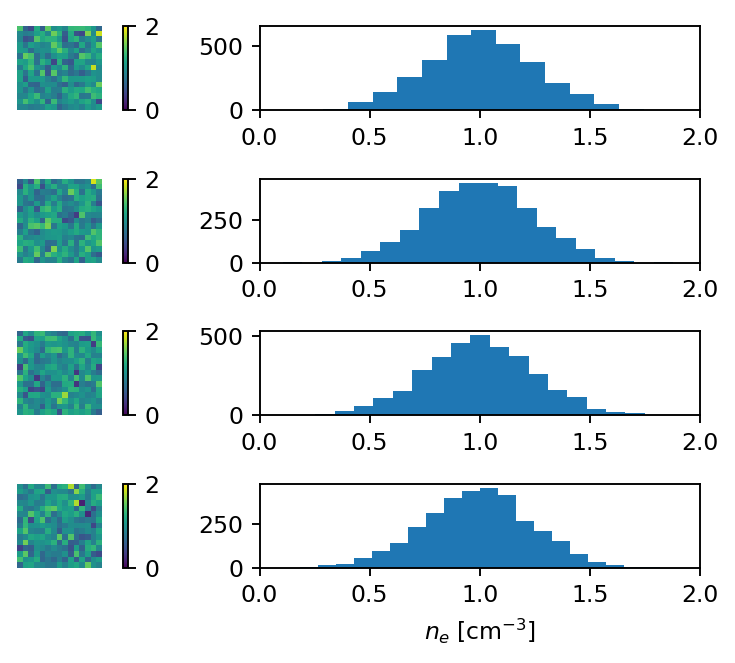

In [14]:
j = 0; plt.figure(dpi=170)
for i in range(4):
    j += 1; plt.subplot(4,2,j)
    plt.imshow(electron_distribution.data[i][0,:,:].value, 
               vmin=0, vmax=2)
    plt.axis('off')
    plt.colorbar()
    j += 1; plt.subplot(4,2,j)
    plt.hist(electron_distribution.data[i].value.ravel(), bins=20)
    plt.xlim(0,2)
plt.xlabel(r'$n_e\; \left[ \rm cm^{-3}\right] $');
plt.tight_layout()

The previous results were generated for the *randomly chosen* random seeds:

In [15]:
electron_distribution.ensemble_seeds

array([1028096589, 2029757511, 2319704186, 1047991784])

Alternatively, to ensure reproducibility, one can explicitly provide the seeds instead of the ensemble size.

In [16]:
electron_distribution = RandomThermalElectrons(
    parameters={'mean': 1.0*u.cm**-3,
                'std': 0.25*u.cm**-3},
    grid=cartesian_grid, ensemble_seeds=[11,22,33,44])

electron_distribution.ensemble_size, electron_distribution.ensemble_seeds

(4, [11, 22, 33, 44])

<!-- Before we exemplified two field types: 'magnetic_field' and 'thermal_electron_density'.  -->
Before moving on, there is one specialised field type which is worth mentioning: the **dummy** field. 

Dummy fields are used when one wants to send  (varying) parameters *directly* 
to the simulator, i.e. this Field object *does not* evaluate anything. 
But the pipeline is still available to vary its parameters.

Why would anyone want to do this? First of all, it is worth remembering that, within the Bayesian framework, the "model" is the Field *together* with the 
Simulator, and the latter can also be parametrised. 
In other words, there can be parameters which control *how to convert* a set of 
models for physical fields into observables. 

Another possibility is that a specific Simulator (e.g. Hammurabi) already
contains built-in parametrised fields which one is willing to make use of. 
Dummy fields allow one to vary those parameters easily.

Below a simple example of how to define and initialize a dummy field.

In [17]:
from imagine import DummyField
    
class exampleDummy(DummyField):
    field_name = 'example_dummy'
    
    @property
    def field_checklist(self):
        return {'A': None, 'B': None, 'C': None}    

In [18]:
dummy = exampleDummy(parameters={'A': 42,
                                 'B': 17*u.kpc,
                                 'C': np.pi},
                     ensemble_size=2)

That is it. Let us inspect the data associated with this Field:

In [19]:
dummy.data

[{'A': 42,
  'B': <Quantity 17. kpc>,
  'C': 3.141592653589793,
  'random_seed': 3778252434},
 {'A': 42,
  'B': <Quantity 17. kpc>,
  'C': 3.141592653589793,
  'random_seed': 1551932314}]

Thus, instead of actual data arrays, the `data` carried by a dummy field is a copy of its parameters dictionary, supplemented by a random seed which can 
optionally be used by the Simulator to generate stochastic fields internally.

### Field factory

Associated with each Field class we need to prepare a FieldFactory class, which will take care (separately) of the scaling of parameter ranges, setting default values and priors over each parameter. This is can done through the  following simple templates

In [20]:
from imagine import GeneralFieldFactory

class ExponentialThermalElectrons_Factory(GeneralFieldFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.field_class = ExponentialThermalElectrons
        self.default_parameters = {'central_density': 1*u.cm**-3,
                                   'scale_radius': 3.0*u.kpc,
                                   'scale_height': 0.5*u.kpc}
        self.priors = {'central_density': FlatPrior(interval=[0,10]*u.cm**-3),
                       'scale_radius': FlatPrior(interval=[1,10]*u.kpc),
                       'scale_height': FlatPrior(interval=[1e-3,5]*u.kpc)}
        
class ConstantMagneticField_Factory(GeneralFieldFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.field_class = ConstantMagneticField
        self.default_parameters = {'Bx': 0.0*u.microgauss,
                                   'By': 5.0*u.microgauss,
                                   'Bz': 0.0*u.microgauss}
        
        self.priors = {'Bx': img.FlatPrior(interval=[-30, 30]*u.microgauss),
                       'By': img.FlatPrior(interval=[-30, 30]*u.microgauss),
                       'Bz': img.FlatPrior(interval=[-10, 10]*u.microgauss)}

We can now create instances of any of these.  The priors, defaults and also parameter ranges can be accessed using the related properties:

In [21]:
Bfactory = ConstantMagneticField_Factory(grid=cartesian_grid)

Bfactory.default_parameters, Bfactory.parameter_ranges, Bfactory.priors

({'Bx': <Quantity 0. uG>, 'By': <Quantity 5. uG>, 'Bz': <Quantity 0. uG>},
 {'Bx': <Quantity [-30.,  30.] uG>,
  'By': <Quantity [-30.,  30.] uG>,
  'Bz': <Quantity [-10.,  10.] uG>},
 {'Bx': <imagine.priors.basic_priors.FlatPrior at 0x7f24d81a1a10>,
  'By': <imagine.priors.basic_priors.FlatPrior at 0x7f24d827e490>,
  'Bz': <imagine.priors.basic_priors.FlatPrior at 0x7f24d8051a50>})

These instances can return Field objects through the 
`generate` method.

In [22]:
newB = Bfactory.generate()
newB.field_name, newB.parameters

('constantB',
 {'Bx': <Quantity 0. uG>, 'By': <Quantity 5. uG>, 'Bz': <Quantity 0. uG>})

The parameters were all set to their default values.
In practice, before the factory object is used, the pipeline 
first sets a list of *active* parameters 
(inactive parameters are kept with their default values)

In [23]:
Bfactory.active_parameters = ['Bx']

The `generate` method can then be called with a dictionary containing *scaled* *dimensionless* variables as values

In [24]:
dimensionless_scaled_variables = {'Bx': 0.7}  # This is NOT 0.7 microgauss!
newB = Bfactory.generate(variables=dimensionless_scaled_variables)
newB.parameters

{'Bx': <Quantity 12. uG>, 'By': <Quantity 5. uG>, 'Bz': <Quantity 0. uG>}

We see that the value corresponds to the 70% of the range between $-30$ and $30\,\mu \rm G$

In the previous definitions, a flat (i.e. uniform) prior was assumed for all the parameters. Setting up a personalised prior is discussed in detail in the [Priors](#Priors) section below. Here we demonstrate how to setup a (truncated) Gaussian prior for the parameters `Bx` and `By`. The priors can be included creating an object `GaussianPrior` for which the mean, standard deviation and range are specified:

In [25]:
muG = u.microgauss

class ConstantMagneticField_Factory(GeneralFieldFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.field_class = ConstantMagneticField
        self.default_parameters = {'Bx': 0.0*muG,
                                   'By': 5.0*muG,
                                   'Bz': 0.0*muG}
        self.priors = {'Bx': img.GaussianPrior(mu=0.0*muG, sigma=10*muG, 
                                               interval=[-30, 30]*muG),
                       'By': img.GaussianPrior(mu=5.0*muG, sigma=5*muG, 
                                               interval=[-30, 30]*muG),
                       'Bz': img.FlatPrior(interval=[-10, 10]*muG)}

Let us now inspect an instance of updated field factory

In [26]:
Bfactory = ConstantMagneticField_Factory(grid=cartesian_grid)
Bfactory.priors

{'Bx': <imagine.priors.basic_priors.GaussianPrior at 0x7f24bad3bfd0>,
 'By': <imagine.priors.basic_priors.GaussianPrior at 0x7f24bad2d2d0>,
 'Bz': <imagine.priors.basic_priors.FlatPrior at 0x7f24bad2d710>}

We can visualise the selected priors through auxiliary methods in the objects. E.g.

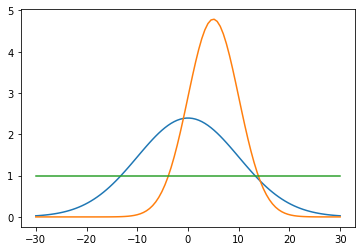

In [27]:
b = np.linspace(-30,30,100)*muG
plt.plot(b, Bfactory.priors['Bx'].pdf_unscaled(b))
plt.plot(b, Bfactory.priors['By'].pdf_unscaled(b))
plt.plot(b, Bfactory.priors['Bz'].pdf_unscaled(b))

More details on how to define personalised priors can be found in the dedicated tutorial.

One final comment:  the generate method can take the arguments `ensemble_seeds` or `ensemble_size` methods, propagating them to the fields it produces.